# I. Initialization : param, import, fonctions utiles



## Param

In [1]:
# Donnees liees au df charge
rep_df = '/gdrive/MyDrive/Colab_Notebooks/Datascientest_epyphyte/'
fichier_df = 'df_iteration3_color.csv' 
fichier_df_seg = 'df_iteration3.csv'
chemin_df = rep_df + fichier_df
chemin_df_seg = rep_df + fichier_df_seg
chemin_color = 'chemin_color'
chemin_segmented = 'chemin_segmented'
chemin_mask = 'chemin_mask'
classe_col = 'plante_maladie'
# chemin_col = 'chemin_color' # OU 'chemin_segmented' : defini plus loin

#Paramètres de modélisation               
largeur = 256
hauteur = 256
profondeur = 3
img_size = (hauteur, largeur)

## Import

In [2]:
#Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns
from PIL import Image

from google.colab import drive
drive._mount('/gdrive')

Mounted at /gdrive


In [3]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from skimage.io import imshow #imread, imshow, concatenate_images

from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback,EarlyStopping

## Fonctions utiles

In [4]:
def lien_to_tableau(lien_img, gray=False, redim=False):
  if gray:
    image = load_img(lien_img, color_mode='grayscale')  
  else:
    image = load_img(lien_img)
  if redim:
    image = image.resize((hauteur, largeur), Image.LANCZOS)
  tableau = np.array(img_to_array(image))
  return tableau

def creer_liste(df, chemin_col, affiche_progres=True):
  liste_image =[]
  # temp pour afficher progres
  k=[]
  if affiche_progres:
    l = len(df)// 8
    k = [l, 2*l, 3*l, 4*l, 5*l, 6*l, 7*l]
  i = 0
  for img_lien in df[chemin_col]:
    liste_image.append(lien_to_tableau(img_lien, False) / np.float32(255))
    # TEMP Affichage
    if i in k:
      print('palier atteint ', i,' / ',len(df))
    i = i +1
  return liste_image

def charger_img_list(df, colonne_chemin, gray=False):
  X = []

  # TEMP affichage progres
  l = len(df)//8
  k = [l, 2*l, 3*l, 4*l, 5*l, 6*l, 7*l]

  if gray:
    for i in range(len(df)):
      img = load_img(df.iloc[i][colonne_chemin], color_mode='grayscale')
      #img = img.resize((largeur, hauteur))
      X.append(img)
  else:
    for i in range(len(df)):
      img = load_img(df.iloc[i][colonne_chemin])
      #img = img.resize((largeur, hauteur))
      X.append(img)

      # TEMP Affichage
      if i in k:
        print('palier atteint ', i,' / ',len(df))

  return X

# Ajouter les photos de chemin_col dans nouvelle col de df (nw=ew_col)
def ajout_col_image(df, chemin_col, new_col, gray=False):
  df[new_col] = charger_img_list(df, chemin_col, gray)
  return df
  
# Ajouter les photos de chemin_col sous forme de tableau dans nouvelle col de df (nw=ew_col)
def ajout_col_image_tableau(df, chemin_col, new_col, gray=False):
  if gray:
    df[new_col] = [np.array(img_to_array(load_img(img, color_mode='grayscale'))) for img in df[chemin_col]]
  else:
    df[new_col] = [np.array(img_to_array(load_img(img))) for img in df[chemin_col]]
  return df

# Affiche image
def affiche_list_image(list_image, nombre_image, fig_size, photo_par_ligne, gray=False):
  plt.figure(figsize= fig_size) 
  for i in range(min(nombre_image, len(list_image))):
      plt.subplot(nombre_image//photo_par_ligne+1,photo_par_ligne,i+1)
      cmap = None
      if gray: cmap = 'gray'
      plt.imshow(list_image[i], cmap=cmap) #attention cmap ignored if prof = 3
      plt.axis('off')
      #plt.title('')

def affiche_list_image_tableau(list_image, nombre_image, fig_size, photo_par_ligne, gray=False):
  plt.figure(figsize= fig_size) 
  for i in range(min(nombre_image, len(list_image))):
      plt.subplot(nombre_image//photo_par_ligne+1,photo_par_ligne,i+1)
      cmap = None
      if gray: cmap = 'gray'
      plt.imshow(array_to_img(list_image[i]), cmap=cmap) #attention cmap ignored if prof = 3
      plt.axis('off')
      #plt.title('')

# afficher matrice de consfusion / heatmap : indice_vs_nom = True ref indice et non nom  
def matrice_confusion(y_test_indice, y_pred_indice, y_test_nom, y_pred_nom, indice_vs_nom=False):
  if indice_vs_nom:
    cm = pd.crosstab(y_test_indice, y_pred_indice, rownames=['Classe réelle'], colnames=['Classe prédite'], margins=True)
  else:
    cm = pd.crosstab(y_test_nom, y_pred_nom, rownames=['Classe réelle'], colnames=['Classe prédite'], margins=True)
  plt.figure(figsize=(20,10))
  vmax = cm.iloc[:-1,:-1].values.max()
  ax = sns.heatmap(cm, annot=True, annot_kws={"size": 8}, fmt='g', cmap='Blues', vmin=0, vmax=vmax)

# Afficher image :  fichier de test_gen, label test/predit, affichage de 5 sur nrow lignes
def Resultat_afficher_image(test_gen2_filenames, y_test_nom, y_pred_nom, nrows=4):
  fig, axes = plt.subplots(nrows=nrows, ncols=5, figsize=(25, nrows*4), subplot_kw={'xticks': [], 'yticks': []})
  for i, ax in enumerate(axes.flat):
      ax.imshow(plt.imread(test_gen2_filenames[i]))
      ax.set_title(f'Reel: {y_test_nom[i]}\n Predit: {y_pred_nom[i]}', fontsize=10)
  #plt.tight_layout()
  plt.show()

# Afficher image :  fichier image directement et non test_gen, label test/predit, affichage de 5 sur nrow lignes
def Resultat_afficher_fichier_image(liste_image_test, y_test_nom, y_pred_nom, nrows=4):
  fig, axes = plt.subplots(nrows=nrows, ncols=5, figsize=(25, nrows*4), subplot_kw={'xticks': [], 'yticks': []})
  for i, ax in enumerate(axes.flat):
      ax.imshow(liste_image_test[i])
      ax.set_title(f'Reel: {y_test_nom[i]}\n Predit: {y_pred_nom[i]}', fontsize=10)
  #plt.tight_layout()
  plt.show()

## Concatener df_phot Seg et Mask

In [ ]:
import pickle

# Choix du df et col/photo : color ou segmented
photo_col = 'chemin_color_photo' #'chemin_color'
#chemin_pickle = rep_df + 'df_chemin_photo_color_court.pickle'
#chemin_pickle = rep_df + 'df_chemin_photo_color_courtplus.pickle'

photo_col_seg = 'chemin_seg_photo' #'chemin_mask_photo'
chemin_pickle = rep_df + 'df_chemin_photo_seg_courtplus.pickle'

df_chemin = pd.read_pickle(chemin_pickle)
#affiche_list_image(np.array(df_chemin[photo_col]), 5,(10,10), 5, False)
#df_chemin.head(1)

photo_col_mask = 'chemin_mask_photo'
chemin_pickle = rep_df + 'df_chemin_photo_mask_courtplus.pickle'

df_chemin2 = pd.read_pickle(chemin_pickle)
#affiche_list_image(np.array(df_chemin[photo_col]), 5,(10,10), 5, False)
#df_chemin.head(1)

In [ ]:
# Merger mask dans seg
df_chemin[photo_col_mask] = df_chemin2[photo_col_mask]
import gc
del df_chemin2
gc.collect()

# Sauvegarde version mergee
import pickle
chemin_seg_pickle = rep_df + 'df_chemin_photo_seg&mask_courtplus.pickle'
df_chemin_photo.to_pickle(chemin_seg_pickle)
print('chargement ok')

# II. Essai segmentation

## Sauvegarde Tableau photo et mask

In [ ]:
# Choix du df et col : color ou segmented
#chemin = chemin_df # df reconstitue pour reger pb sur les liens color
#chemin_col = chemin_color #'chemin_color'
chemin = chemin_df_seg # df avec pb sur liens color mais contenant liens segmente + mask

# Chargement
df_chemin = pd.read_csv(chemin)
print('df_chemin shape/classes: ',df_chemin.shape, len(df_chemin[classe_col].unique()))

df_chemin shape/classes:  (54332, 6) 38


In [ ]:
import os
df_chemin['lien_color_ok']=[os.path.exists(fichier) for fichier in df_chemin[chemin_color]]

In [ ]:
# Utilisation df court
_, df_chemin_court = train_test_split(df_chemin[df_chemin.lien_color_ok], test_size=0.1, stratify=df_chemin[df_chemin.lien_color_ok][classe_col])
print('df_chemin_court shape/classes: ', len(df_chemin_court), len(df_chemin_court.plante_maladie.unique()))

df_chemin_court shape/classes:  5161 37


In [ ]:
import gc
del df_chemin
gc.collect()

1523

In [ ]:
# Creation et sauvegarde liste NORMEE : couleur
liste_image = creer_liste(df_chemin_court, chemin_color, True)

In [ ]:
import pickle
chemin_tableau_pickle = rep_df + 'liste_tableau_color_court.pickle'

with open(chemin_tableau_pickle, 'wb') as f:
  pickle.dump(liste_image, f)
print('sauvegarde done')

sauvegarde done


In [ ]:
# Creation et sauvegarde liste NORMEE : mask
liste_image = creer_liste(df_chemin_court, chemin_mask, True)

In [ ]:
import pickle
chemin_tableau_pickle = rep_df + 'liste_tableau_color_mask_n&b_court.pickle'

with open(chemin_tableau_pickle, 'wb') as f:
  pickle.dump(liste_image, f)
print('sauvegarde done')

sauvegarde done


In [ ]:
liste_image=[]

In [ ]:
import gc
del df_chemin_court
gc.collect()

1252

## Chargement liste image / tableau seg & mask

In [ ]:
import pickle
chemin_tableau_pickle = rep_df + 'liste_tableau_color_court.pickle'
with open(chemin_tableau_pickle, 'rb') as f:
  liste_image_color = pickle.load(f)
np.shape(liste_image_color)

(5161, 256, 256, 3)

In [ ]:
import pickle
chemin_tableau_pickle = rep_df + 'liste_tableau_color_mask_n&b_court.pickle'
with open(chemin_tableau_pickle, 'rb') as f:
  liste_image_mask = pickle.load(f)
np.shape(liste_image_mask)

(5161, 256, 256, 1)

## Creation / entrainement du modele

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(liste_image_color, liste_image_mask, test_size=0.4)#, stratify=df_chemin[classe_col])  #, random_state=40)
print('train shape seg/mask : ',len(X_train), len(y_train))
print('test shape seg/masks : ',len(X_test), len(y_test))

train shape seg/mask :  3096 3096
test shape seg/masks :  2065 2065


In [ ]:
import gc
del liste_image_color
del liste_image_mask
gc.collect()

435

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)#, stratify=df_chemin[classe_col])  #, random_state=40)
print('train shape seg/mask : ',len(X_train), len(y_train))
print('test shape seg/masks : ',len(X_test), len(y_test))

train shape seg/mask :  2476 2476
test shape seg/masks :  620 620


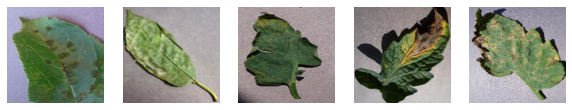

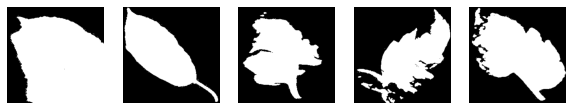

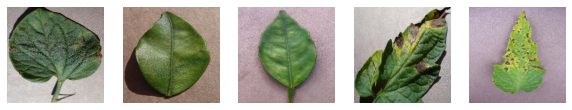

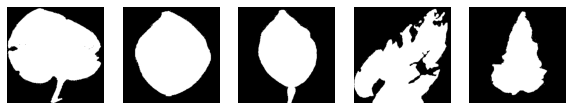

In [ ]:
affiche_list_image_tableau(X_train, 5,(10,10), 5, False)
affiche_list_image_tableau(y_train, 5,(10,10), 5, True)
affiche_list_image_tableau(X_test, 5,(10,10), 5, False)
affiche_list_image_tableau(y_test, 5,(10,10), 5, True)

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
y_train.shape

(2476, 256, 256, 1)

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
from tensorflow.keras.layers import Input, BatchNormalization, Activation #, Dense, Dropout
from tensorflow.keras.layers import  Conv2DTranspose
from tensorflow.keras.layers import concatenate  #, add
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau  #EarlyStopping

input_img = Input((hauteur, largeur, profondeur), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
callbacks = [
    #EarlyStopping(monitor='val_accuracy', min_delta=0.0002, patience =3),
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(rep_df+'/model_unet_checkpoint', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_test, y_test))

Epoch 1/50
78/78 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.9095WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 00001: val_loss improved from inf to 0.24020, saving model to model-tgs-salt.h5
78/78 [==============================] - 37s 287ms/step - loss: 0.1949 - accuracy: 0.9095 - val_loss: 0.2402 - val_accuracy: 0.9094 - lr: 0.0010
Epoch 2/50
78/78 [==============================] - ETA: 0s - loss: 0.0896 - accuracy: 0.9451WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 00002: val_loss improved from 0.24020 to 0.12354, saving model to model-tgs-salt.h5
78/78 [==============================] - 20s 254ms/step - loss: 0.0896 - accuracy: 0.9451 - val_loss: 0.1235 - val_accuracy: 0.9317 - lr: 0.0010
Epoch 3/50
78/78 [==============================] - ETA:

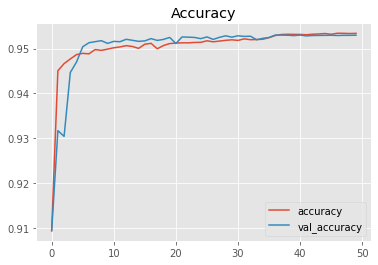

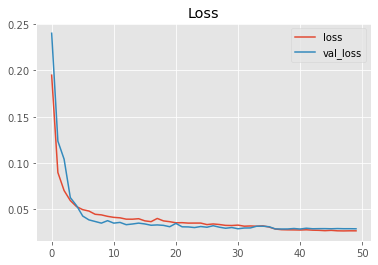

In [ ]:
pd.DataFrame(results.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(results.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
model_path = rep_df+'220117_model_unet_color_plus'
model.save(model_path)

INFO:tensorflow:Assets written to: /gdrive/MyDrive/Colab_Notebooks/Datascientest_epyphyte//220117_model_unet_color_plus/assets


In [ ]:
model.save_weights(model_path+'/checkpoint') #.format(epoch=0))

# III. Evaluation

## Evaluation / prediction : X_Test

In [6]:
model_path = rep_df+'220117_model_unet_color_plus'
model = load_model(model_path)

In [7]:
# load meilleur model
model.load_weights(model_path+'/checkpoint')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_test, y_test, verbose=1)

20/20 [==============================] - 2s 77ms/step - loss: 0.0287 - accuracy: 0.9530


[0.028737865388393402, 0.9529750943183899]

In [ ]:
# Prediction train / test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

20/20 [==============================] - 1s 69ms/step


In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

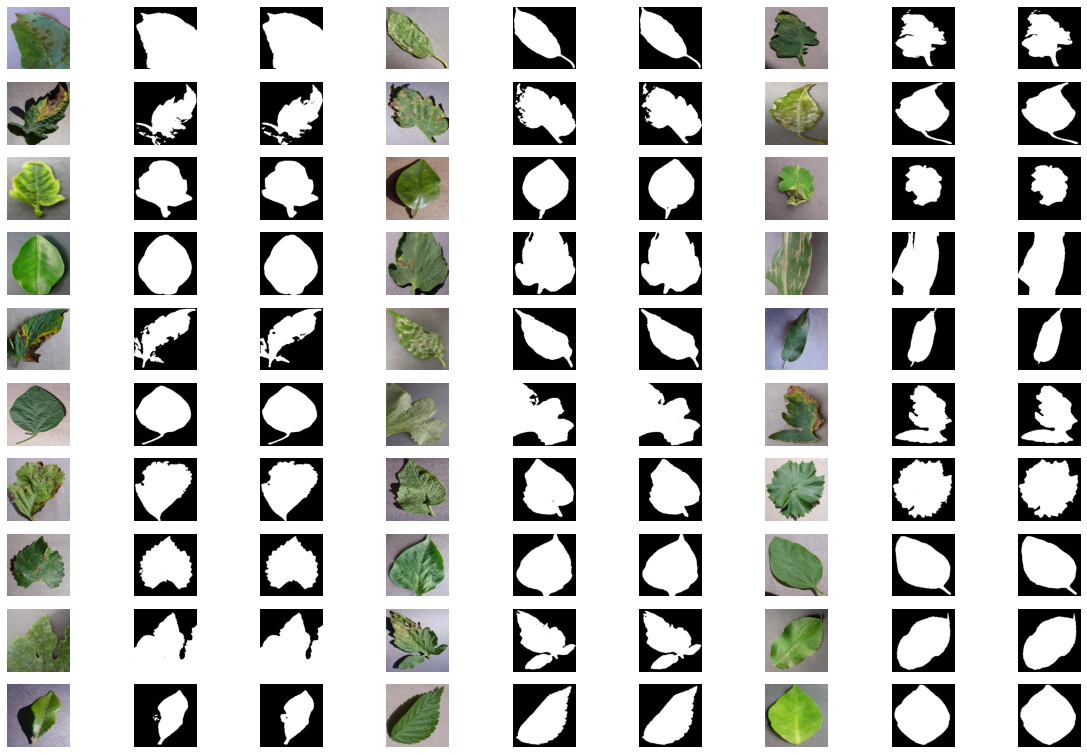

In [ ]:
liste_concat = []
for i in range(40):
  liste_concat.append(X_train[i])
  liste_concat.append(y_train[i])
  liste_concat.append(preds_train_t[i])
affiche_list_image_tableau(liste_concat, 90, (20,15), 9, True)

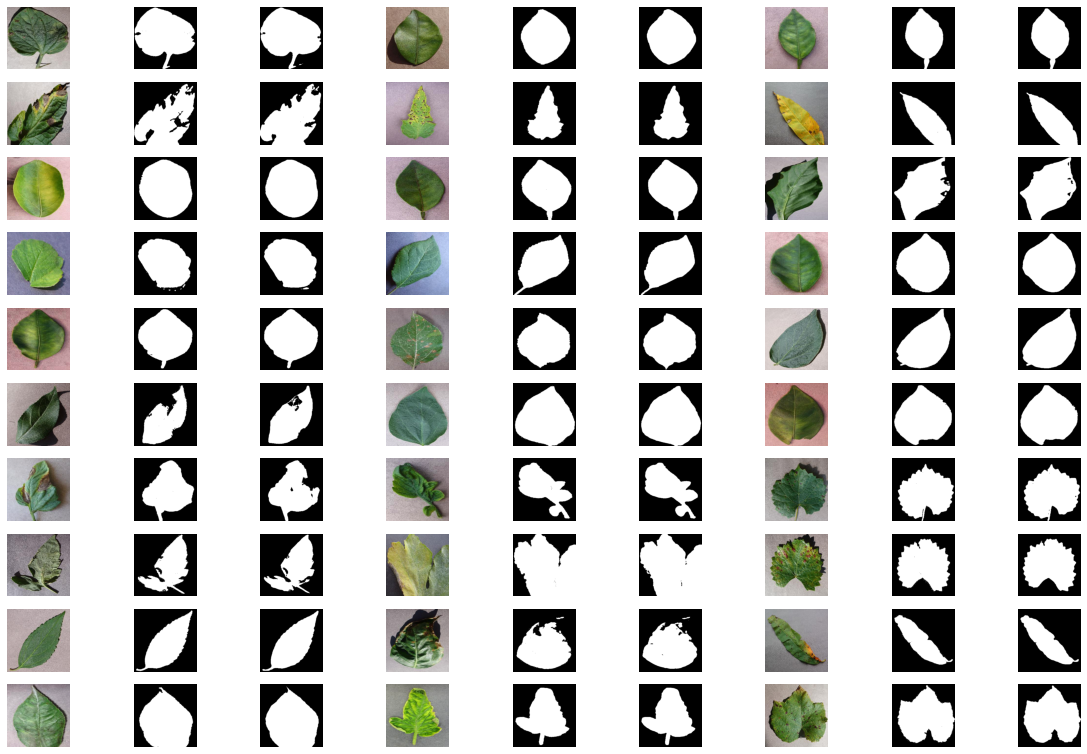

In [ ]:
liste_concat = []
for i in range(40):
  liste_concat.append(X_test[i])
  liste_concat.append(y_test[i])
  liste_concat.append(preds_test_t[i])
affiche_list_image_tableau(liste_concat, 90, (20,15), 9, True)

## Evaluation / prediction : autres

### Prediction sur df_reel

In [ ]:
chemin_image = '/gdrive/MyDrive/epyphyte/donnees/test/'  # 53 photos réelles
# '/gdrive/MyDrive/epyphyte/donnees/test2' # 53 photos color
# '/gdrive/MyDrive/epyphyte/donnees/test3' # 53 photos segmented

import os
df_reel = pd.DataFrame()
for (repertoire, sousRepertoires, fichiers) in os.walk(chemin_image):
    df_temp = pd.DataFrame(data=fichiers, columns=['fichier'])
    df_temp['dossier'] = repertoire
    df_reel = pd.concat([df_reel, df_temp], axis = 0)

df_reel['chemin_color'] = df_reel['dossier'] +'/'+ df_reel['fichier']
df_reel['plante_maladie']=[x[len(chemin_image):] for x in df_reel.dossier]
df_reel['plante']=[x.split('___')[0] for x in df_reel.plante_maladie]   
df_reel['maladie']=[x.split('___')[1] for x in df_reel.plante_maladie]
df_reel.head(1)

fichier  ...      maladie
0  Mildiou1.jpg  ...  Late_blight

[1 rows x 6 columns]

In [ ]:
chemin_col = 'chemin_color'  #OU 'chemin_mask' ou 'chemin_color' ou 'chemin_segmented'
photo_col = chemin_col+'_photo'
# Ajouter photo dans df
df_reel = ajout_col_image(df_reel, chemin_col, photo_col)

palier reached  6
palier reached  12
palier reached  18
palier reached  24
palier reached  30
palier reached  36
palier reached  42


In [ ]:
df_reel.head(1)

fichier  ...      maladie
0  Mildiou1.jpg  ...  Late_blight

[1 rows x 6 columns]

In [ ]:
# Sauvegarde liste NORMEE
df = df_reel
chemin_col = chemin_color
liste_image =[]

# TEMP affichage progres
l = len(df)//8
k = [1, l, 2*l, 3*l, 4*l, 5*l, 6*l, 7*l]
i = 0
for img_lien in df[chemin_col]:
  liste_image.append(lien_to_tableau(img_lien, False, True) / np.float32(255))
  # TEMP Affichage
  if i in k:
    print('palier reached ', i)
  i = i +1

palier reached  1
palier reached  6
palier reached  12
palier reached  18
palier reached  24
palier reached  30
palier reached  36
palier reached  42


In [ ]:
liste_image = np.array(liste_image)
liste_image.shape

(53, 256, 256, 3)

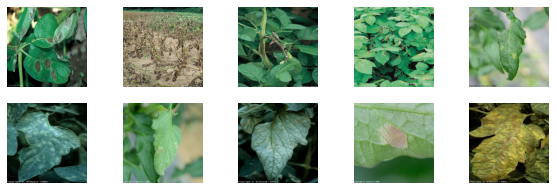

In [ ]:
affiche_list_image_tableau(liste_image, 10, (10,5), 5, False)

In [ ]:
# Prediction sur train et test
preds_test2 = model.predict(liste_image, verbose=1)
# Threshold predictions
preds_test_t2 = (preds_test2 > 0.5).astype(np.uint8)

2/2 [==============================] - 1s 1s/step


In [ ]:
liste_concat = []
for i in range(len(liste_image)):
  liste_concat.append(liste_image[i])
  liste_concat.append(preds_test_t2[i])

In [ ]:
affiche_list_image_tableau(liste_concat, 106, (30,30), 10, True)

Output hidden; open in https://colab.research.google.com to view.

### Prediction sur df_reel

#### Prediction : fonction

In [15]:
def prediction_mask(lien_echantillon):
  # Constitun df_reel avec echantillon
  import os
  df_reel = pd.DataFrame()
  for (repertoire, sousRepertoires, fichiers) in os.walk(lien_echantillon):
      df_temp = pd.DataFrame(data=fichiers, columns=['fichier'])
      df_temp['dossier'] = repertoire
      df_reel = pd.concat([df_reel, df_temp], axis = 0)

  df_reel['chemin_color'] = df_reel['dossier'] +'/'+ df_reel['fichier']
  df_reel['plante_maladie']=[x[len(lien_echantillon):] for x in df_reel.dossier]
  df_reel['plante']=[x.split('___')[0] for x in df_reel.plante_maladie]   
  df_reel['maladie']=[x.split('___')[1] for x in df_reel.plante_maladie]
  df_reel.head(1)

  #chemin_col = 'chemin_color'  #OU 'chemin_mask' ou 'chemin_color' ou 'chemin_segmented'
  #photo_col = chemin_col+'_photo'
  # Ajouter photo dans df
  #df_reel = ajout_col_image(df_reel, chemin_col, photo_col)

  # Sauvegarde des images dans liste NORMEE 
  liste_image =[]
  # TEMP affichage progres
  l = len(df_reel)//8
  k = [1, l, 2*l, 3*l, 4*l, 5*l, 6*l, 7*l]
  i = 0
  for img_lien in df_reel[chemin_color]:
    liste_image.append(lien_to_tableau(img_lien, False, True) / np.float32(255))
    # TEMP Affichage
    if i in k:
      print('palier reached ', i)
    i = i +1
  liste_image = np.array(liste_image)
  print('Nombre de photos / shape :',liste_image.shape)

  # Prediction sur train et test
  preds_test = model.predict(liste_image, verbose=1)
  # Threshold predictions
  preds_test_t = (preds_test > 0.5).astype(np.uint8)

  # affichage liste et prediction
  liste_concat = []
  for i in range(len(liste_image)):
    liste_concat.append(liste_image[i])
    liste_concat.append(preds_test_t[i])
  affiche_list_image_tableau(liste_concat, 106, (30,30), 10, True)

In [10]:
chemin_image1 = '/gdrive/MyDrive/epyphyte/donnees/test/'  # 53 photos réelles
chemin_image2 = '/gdrive/MyDrive/epyphyte/donnees/test2' # 53 photos color
chemin_image3 = '/gdrive/MyDrive/epyphyte/donnees/test3' # 53 photos segmented
chemin_image4 = '/gdrive/MyDrive/epyphyte/donnees/test4' # 26 photos

#### Prediction test 1

In [17]:
prediction_mask(chemin_image1)

Output hidden; open in https://colab.research.google.com to view.

#### Prediction test 2

In [18]:
prediction_mask(chemin_image2)

Output hidden; open in https://colab.research.google.com to view.

#### Prediction test 3

palier reached  1
palier reached  6
palier reached  12
palier reached  18
palier reached  24
palier reached  30
palier reached  36
palier reached  42
Nombre de photos / shape : (53, 256, 256, 3)
2/2 [==============================] - 0s 188ms/step


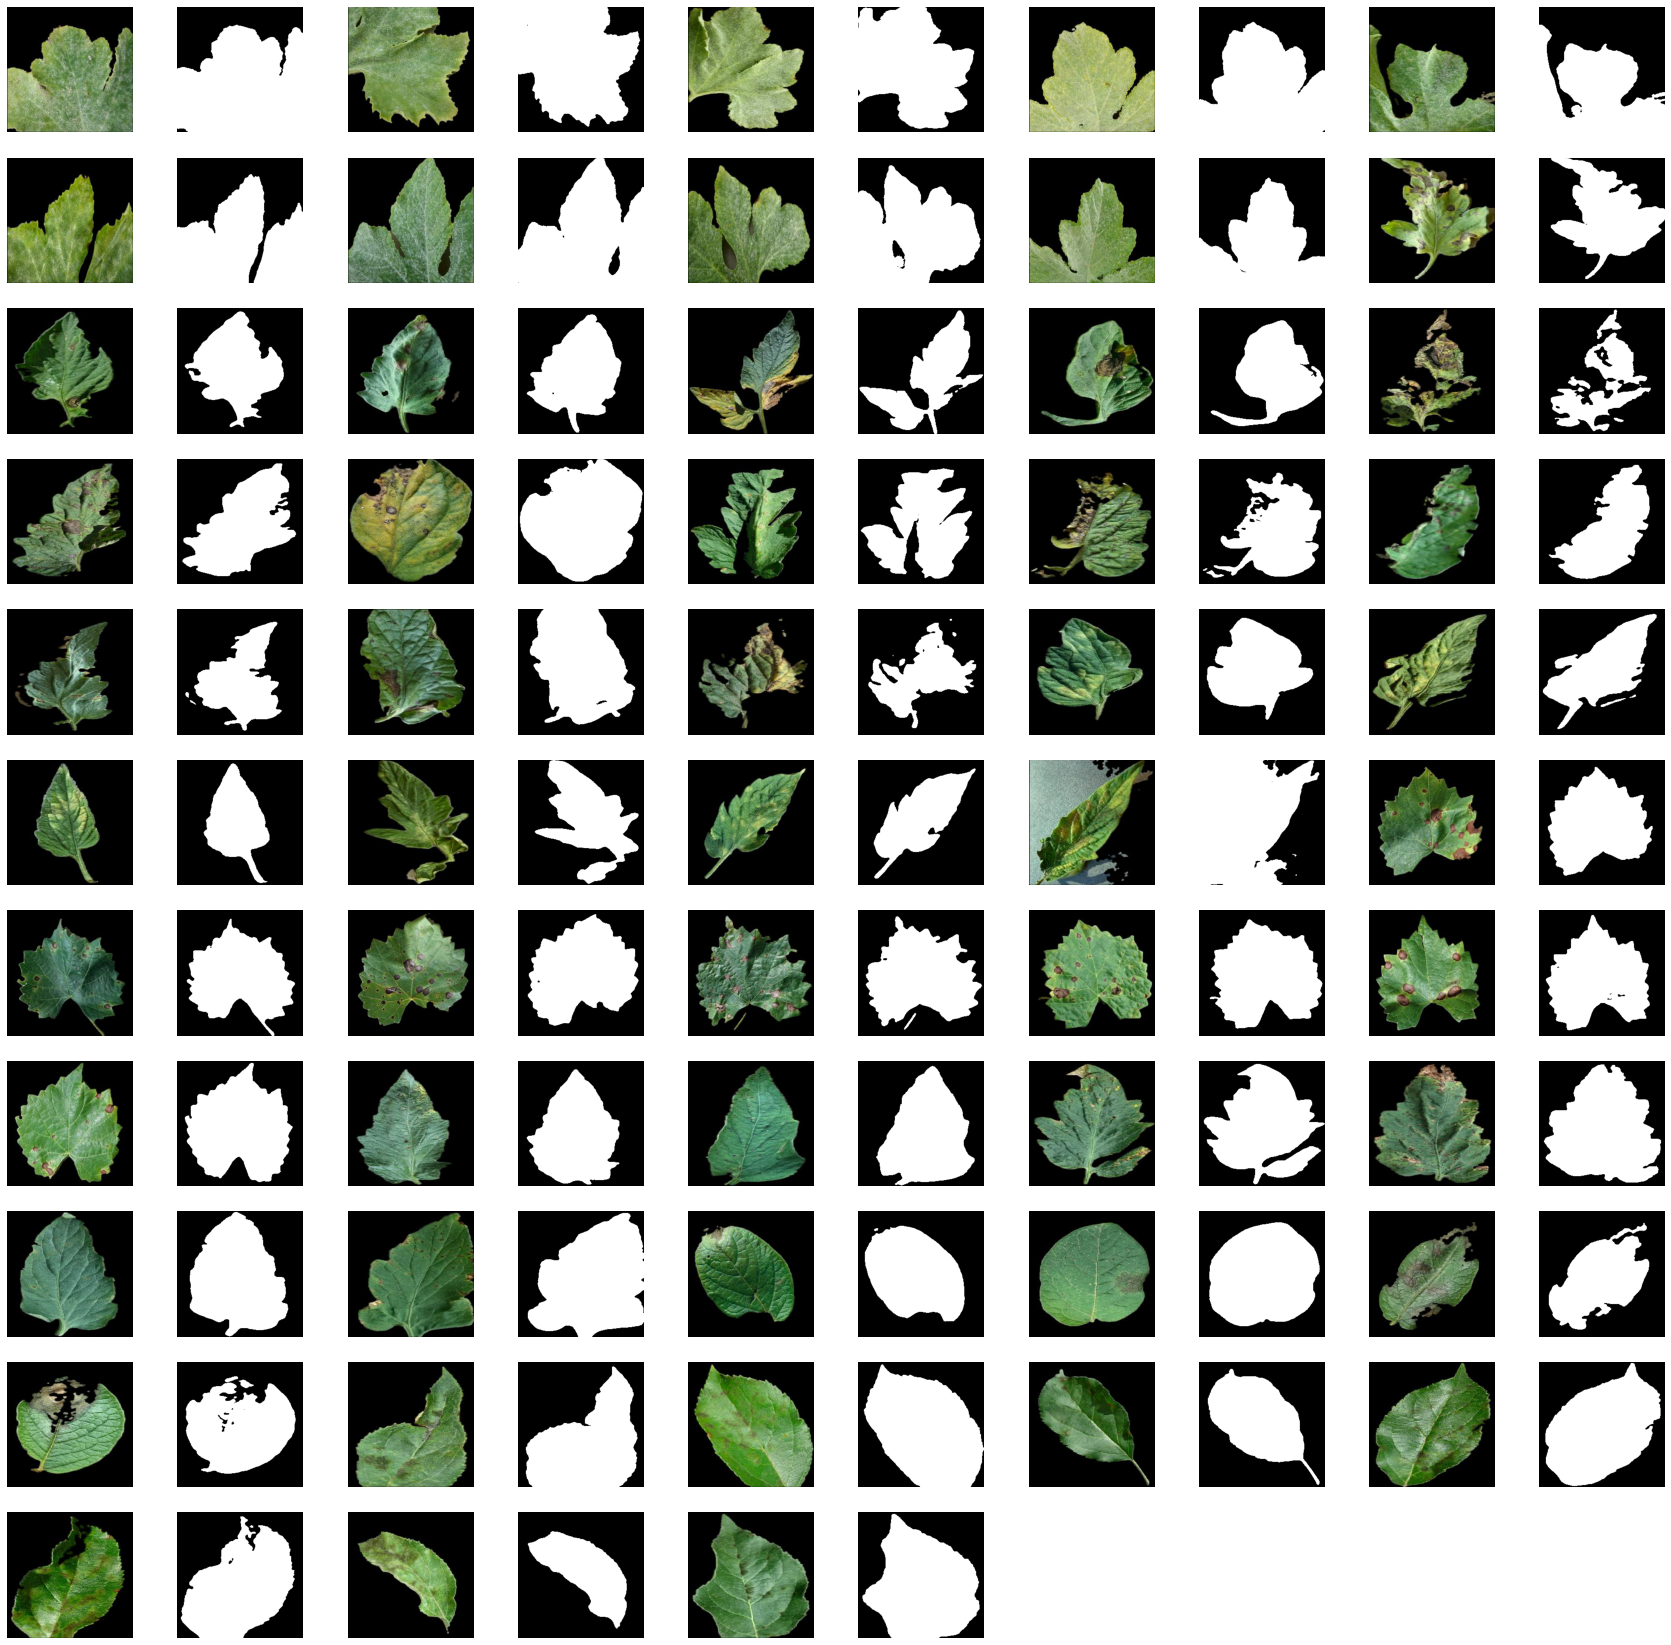

In [19]:
prediction_mask(chemin_image3)

#### Prediction Test4

palier reached  1
palier reached  3
palier reached  6
palier reached  9
palier reached  12
palier reached  15
palier reached  18
palier reached  21
Nombre de photos / shape : (26, 256, 256, 3)
1/1 [==============================] - 10s 10s/step


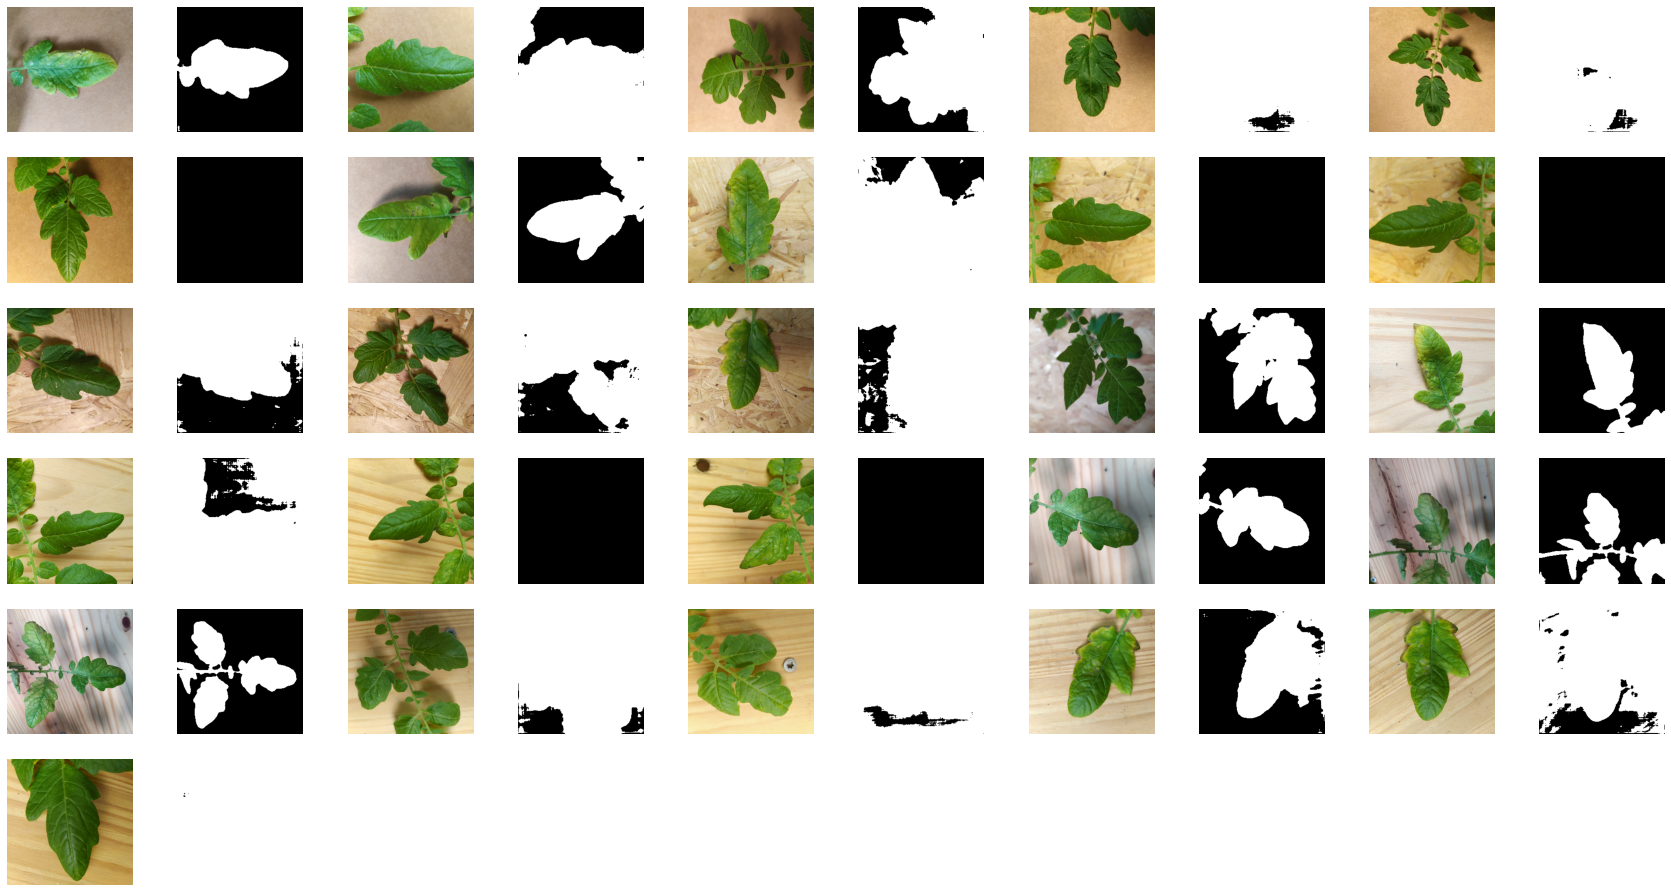

In [16]:
prediction_mask(chemin_image4)

# FIN